In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-f_i1_nyk
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-f_i1_nyk
  Resolved https://github.com/tensorflow/examples.git to commit 2741b9ea31622676451e2ce1414d233de45f915f
  Created wheel for tensorflow-examples: filename=tensorflow_examples-2741b9ea31622676451e2ce1414d233de45f915f_-py3-none-any.whl size=299718 sha256=50d5127669ccb29bd552f1def625d7a04a3edca301f313adfc0d17767b4cf22a
  Stored in directory: /tmp/pip-ephem-wheel-cache-5q6y58ap/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa

In [2]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os, time
from kaggle_datasets import KaggleDatasets
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

2022-12-06 19:57:17.052408: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 19:57:17.052589: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print(tf.__version__)

2.4.1


In [4]:
# Configuration
class Configuration:
    """Class containing most of the parameters or hyperparameters used
    throughout the notebook."""
    
    epochs = 50
    MONET_TFREC = "/monet_tfrec/*.tfrec"
    MONET_JPG = "/monet_jpg/*.jpg"
    PHOTO_TFREC = "/photo_tfrec/*.tfrec"
    PHOTO_JPG = "/photo_jpg/*.jpg"
    BATCH_SIZE = 8
    IMAGE_SIZE = [256, 256]
    BUFFER = 10000
    steps_per_epoch = 0
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

cfg = Configuration()

In [5]:
# Setting up the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Device: grpc://10.0.0.2:8470


2022-12-06 19:57:23.013168: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 19:57:23.015630: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-12-06 19:57:23.015672: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 19:57:23.015699: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8e6effe9e9e0): /proc/driver/nvidia/version does not exist
2022-12-06 19:57:23.018477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

Number of replicas: 8


Now since we would be going to make the dataset infinitely repeatable, it would be necessary for us to define the number of steps that has to be taken at each epoch. So let's just set up that also.

In [6]:
monet_jpg = tf.io.gfile.glob("../input/gan-getting-started/monet_jpg/*.jpg")
cfg.steps_per_epoch = len(monet_jpg)

In [7]:
class MonetDataset:
        def __init__(self,config):
            """Creates a data of TFRecord files."""
            self.cfg = config
            gcs_path = KaggleDatasets().get_gcs_path()
            self.monet_files = tf.io.gfile.glob(gcs_path+self.cfg.MONET_TFREC)
            self.photo_files = tf.io.gfile.glob(gcs_path + self.cfg.PHOTO_TFREC)
            
        def decode_image(self, image):
            """Function to preprocess the image prior to training."""
            img = tf.image.decode_jpeg(image, channels=3)
            img = tf.cast(img, tf.float32)
            img = img/127.5 - 1
            img = tf.reshape(img, [*self.cfg.IMAGE_SIZE, 3])
            return img
        
        def read_tfrecord(self, instance):
            """Function to extract data from TFRecordDataset Instance."""
            tfrecordformat = {
                    "image_name": tf.io.FixedLenFeature([], tf.string),
                    "image": tf.io.FixedLenFeature([], tf.string),
                    "target": tf.io.FixedLenFeature([], tf.string)
                   }
            example = tf.io.parse_single_example(instance, tfrecordformat)
            return self.decode_image(example["image"])
        
        def prepare_dataset(self, monet=True):
            """Main function to prepare the input pipeline.
            Args: 
            monet- bool value
            Determines if we wanna generate monet dataset or the photo dataset"""
            dataset = tf.data.TFRecordDataset(self.monet_files if monet else self.photo_files, num_parallel_reads=AUTOTUNE)
            dataset = dataset.map(self.read_tfrecord, num_parallel_calls=AUTOTUNE)
            dataset = dataset.map(self.random_jitter, num_parallel_calls=AUTOTUNE)
            dataset = dataset.repeat()
            dataset = dataset.shuffle(self.cfg.BUFFER)
            dataset = dataset.batch(self.cfg.BATCH_SIZE)
            dataset = dataset.prefetch(AUTOTUNE)
            return dataset

        def random_crop(self, image):
            """Function to perform random cropping."""
            image = tf.image.random_crop(image, [*self.cfg.IMAGE_SIZE, 3])
            return image
        
        def random_jitter(self, image):
            """Function to perform random jittering."""
            image = tf.image.resize(image, [286, 286])
            image = self.random_crop(image)
            
            if tf.random.uniform([], 0, 1) > 0.5:
                image = tf.image.random_flip_left_right(image)
            return image
        
        def visualize_data(self, data):
            """Utility function to visualize the samples in the dataset instance being provided."""
            fig, ax = plt.subplots(2, self.cfg.BATCH_SIZE//2, figsize=(16, 4)) # Figsize->W x H
            ax = ax.flatten()
            for i, im in zip(range(self.cfg.BATCH_SIZE), data):
                im = im*0.5 + 0.5
                ax[i].imshow(im)
                ax[i].axis("off")
            plt.show()

In [8]:
# Creating instance of dataset
dataset = MonetDataset(Configuration())

2022-12-06 19:57:29.406088: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-06 19:57:29.450476: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [9]:
# Creating seperate monet and photo dataset.
monet_dataset = dataset.prepare_dataset(monet=True)
photo_dataset = dataset.prepare_dataset(monet=False)

In [25]:
monet_jpg[0]

'../input/gan-getting-started/monet_jpg/f4413e97bd.jpg'

In [38]:
# Import the PIL library
from PIL import Image

# Open the image file
img = Image.open(monet_jpg[1])

# Add random noise to the image pixels
data = np.asarray(img)
jittered_image = data + np.random.uniform(-255, 255, size=data.shape)

# Save the jittered image
#Image.fromarray(jittered_image).save('jittered_image.jpg')

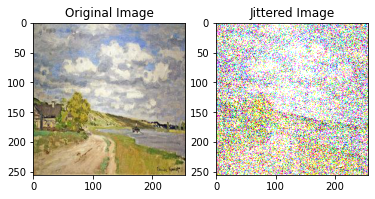

In [39]:
import matplotlib.pyplot as plt

# Open the jittered image
#jittered_image = Image.open(monet_jpg[0])

# Display the original and jittered images side-by-side
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(jittered_image)
plt.title('Jittered Image')

plt.show()

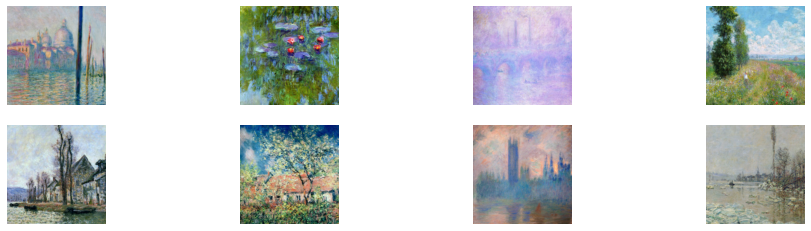

In [10]:
example = next(iter(monet_dataset))
dataset.visualize_data(example)

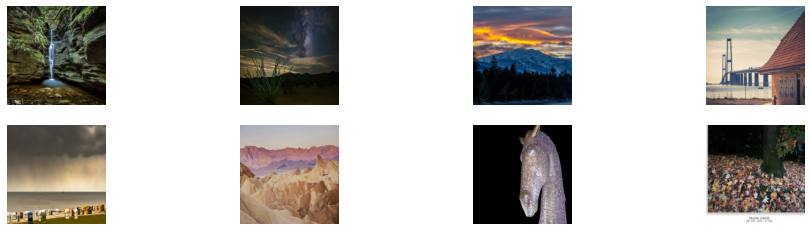

In [11]:
dataset.visualize_data(next(iter(photo_dataset)))

In [12]:
class CyclicGAN(tf.keras.Model):
    """Class to build and train custom CyclicGAN architecture."""
    def __init__(self, 
                monet_generator, 
                photo_generator,
                monet_discriminator,
                photo_discriminator,
                lambda_cyclic = 10):
        super(CyclicGAN, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_ = lambda_cyclic
    
    def compile(self,
                m_gen_optimizer,
                p_gen_optimizer,
                m_disc_optimizer,
                p_disc_optimizer,
                gen_loss,
                disc_loss,
                cyclic_loss,
                identity_loss
               ):
        """Function to set the optimizers and metrics used for the model training."""
        super(CyclicGAN, self).compile()
        self.m_gen_optimizer= m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss = gen_loss
        self.disc_loss = disc_loss
        self.cyclic_loss = cyclic_loss
        self.identity_loss = identity_loss
    
    def train_step(self, batch_data):
        """Function to run a single step of training."""
        real_monet, real_photo = batch_data
        with tf.GradientTape(persistent=True) as tape:
            
            # Getting Generator and Discriminator output. 
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)
            
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)
            
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            
            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            
            # Calculate Losses
            cycle_loss = self.lambda_*(self.cyclic_loss(real_monet, cycled_monet)+self.cyclic_loss(real_photo, cycled_photo))
            identity_loss = self.lambda_ * (self.identity_loss(real_monet, same_monet) + self.identity_loss(real_photo, same_photo))
            
            monet_gen_loss = self.gen_loss(disc_fake_monet)
            photo_gen_loss = self.gen_loss(disc_fake_photo)
            
            total_monet_gen_loss = monet_gen_loss + cycle_loss + identity_loss
            total_photo_gen_loss = photo_gen_loss + cycle_loss + identity_loss
            
            monet_disc_loss = self.disc_loss(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss(disc_real_photo, disc_fake_photo)
            
            # Calculate Gradients
            monet_gen_gradient = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
            photo_gen_gradient = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
            
            monet_disc_gradient = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
            photo_disc_gradient = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)
            
            self.m_gen_optimizer.apply_gradients(zip(monet_gen_gradient, self.m_gen.trainable_variables))
            self.p_gen_optimizer.apply_gradients(zip(photo_gen_gradient, self.p_gen.trainable_variables))
            
            # Apply Gradients
            self.m_disc_optimizer.apply_gradients(zip(monet_disc_gradient, self.m_disc.trainable_variables))
            self.p_disc_optimizer.apply_gradients(zip(photo_disc_gradient, self.p_disc.trainable_variables))
            
            return {
                "monet_generator_loss": total_monet_gen_loss,
                "monet_discriminator_loss": monet_disc_loss,
                "photo_generator_loss": total_photo_gen_loss,
                "photo_discriminator_loss": photo_disc_loss
            }

In [13]:
OUTPUT_CHANNELS = 3
with strategy.scope():
    monet_gen = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")
    photo_gen = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type="instancenorm")

    monet_disc = pix2pix.discriminator(norm_type="instancenorm", target=False)
    photo_disc = pix2pix.discriminator(norm_type="instancenorm", target=False)

In [14]:
with strategy.scope():
    model = CyclicGAN(monet_gen, photo_gen, monet_disc, photo_disc)
    
    # Prepairing the loss functions.
    def generator_loss(generated_op):
        return cfg.loss(tf.ones_like(generated_op), generated_op)
    
    def discriminator_loss(disc_real_op, disc_fake_op):
        real_loss = cfg.loss(tf.ones_like(disc_real_op), disc_real_op)
        fake_loss = cfg.loss(tf.zeros_like(disc_fake_op), disc_fake_op)
        total_loss = real_loss + fake_loss
        return total_loss * 0.5
    
    def cyclic_loss(real_image, cycled_image):
        return tf.reduce_mean(tf.abs(real_image - cycled_image))
    
    def identity_loss(real_image, same_image):
        return tf.reduce_mean(tf.abs(real_image-same_image))
    
    m_gen_optim = tf.keras.optimizers.Adam(lr=2e-04, beta_1=0.5)
    p_gen_optim = tf.keras.optimizers.Adam(lr=2e-04, beta_1=0.5)
    m_disc_optim = tf.keras.optimizers.Adam(lr=2e-04, beta_1=0.5)
    p_disc_optim = tf.keras.optimizers.Adam(lr=2e-04, beta_1=0.5)

In [15]:
with strategy.scope():
    model.compile(m_gen_optim,
                 p_gen_optim,
                 m_disc_optim,
                 p_disc_optim,
                 generator_loss,
                 discriminator_loss,
                 cyclic_loss,
                 identity_loss)

# Visualize the model

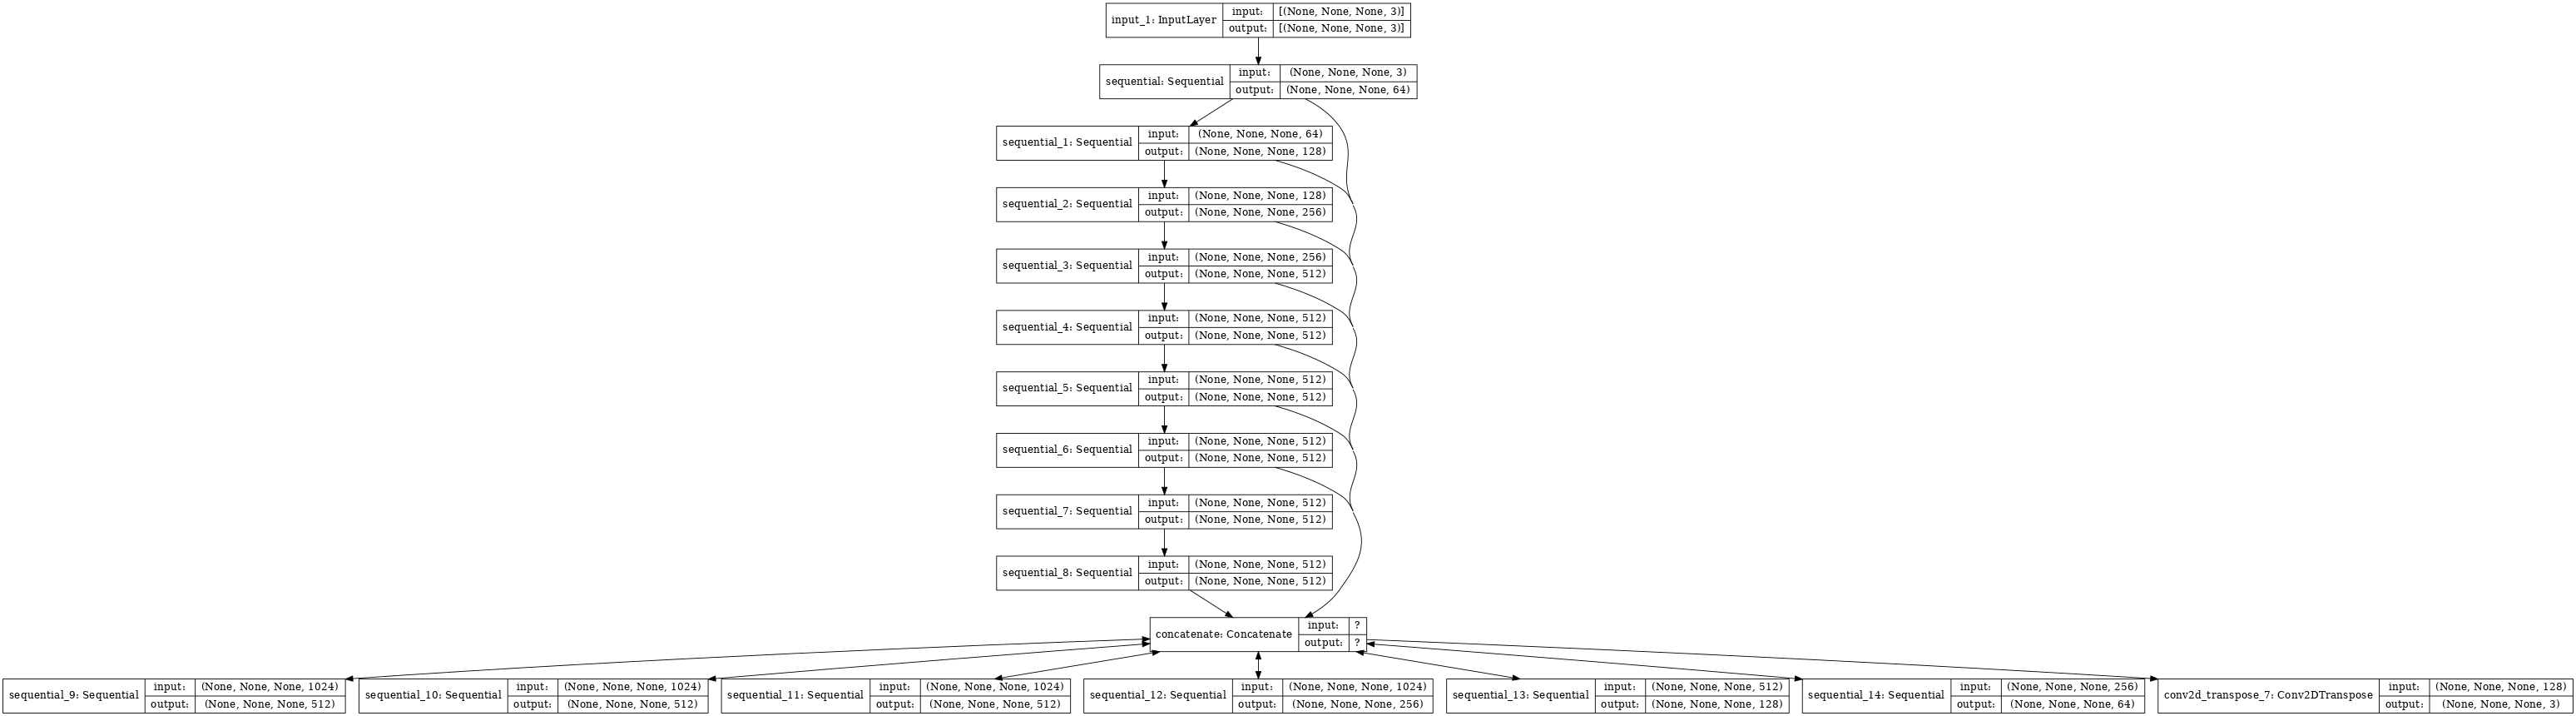

In [16]:
# Visualizing Generator model.
tf.keras.utils.plot_model(monet_gen, show_shapes=True, dpi=64)

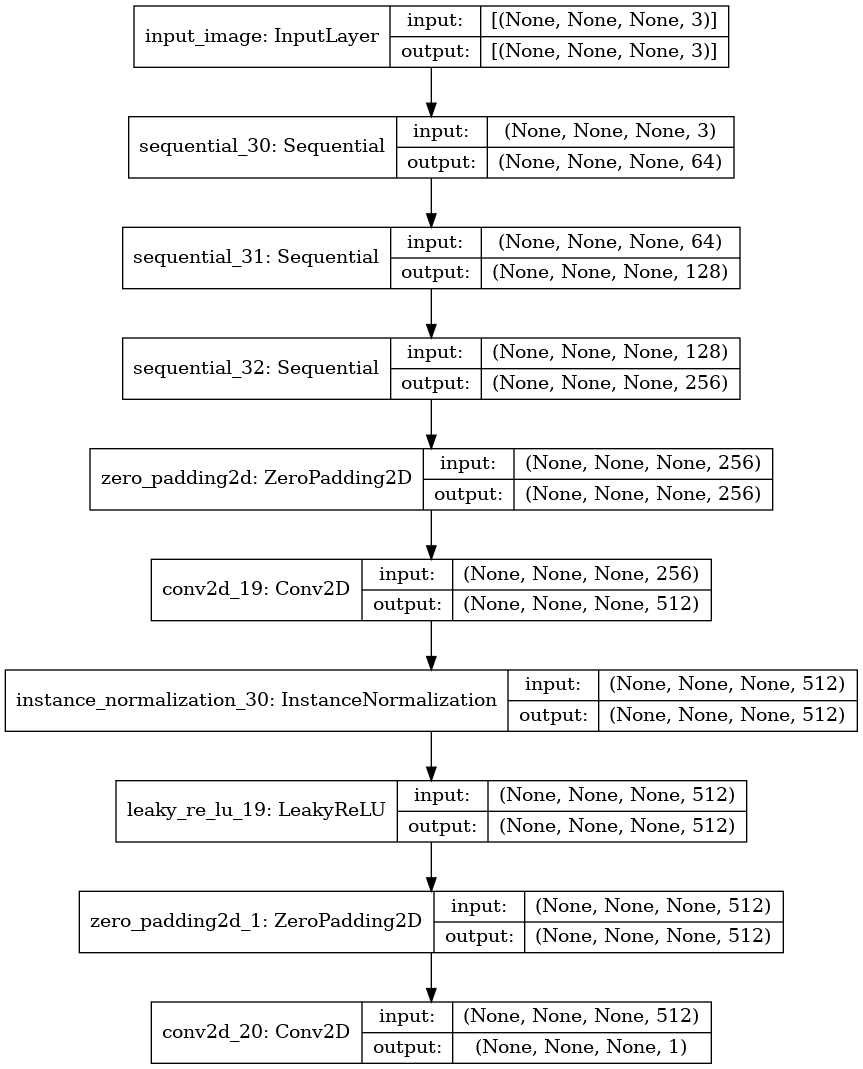

In [17]:
# Visualizing Discriminator model
tf.keras.utils.plot_model(monet_disc, show_shapes=True, dpi=96)

# Train the model

In [22]:
with strategy.scope():
    model.fit(tf.data.Dataset.zip((monet_dataset, photo_dataset)), epochs=cfg.epochs,
             steps_per_epoch = cfg.steps_per_epoch)

Epoch 1/50
300/300 [==============================] - 43s 135ms/step - monet_generator_loss: 3.4652 - monet_discriminator_loss: 0.4680 - photo_generator_loss: 2.9436 - photo_discriminator_loss: 0.5920
Epoch 2/50
300/300 [==============================] - 40s 134ms/step - monet_generator_loss: 3.4526 - monet_discriminator_loss: 0.4654 - photo_generator_loss: 2.9586 - photo_discriminator_loss: 0.5896
Epoch 3/50
300/300 [==============================] - 40s 134ms/step - monet_generator_loss: 3.4468 - monet_discriminator_loss: 0.4445 - photo_generator_loss: 2.9356 - photo_discriminator_loss: 0.6064
Epoch 4/50
300/300 [==============================] - 40s 134ms/step - monet_generator_loss: 3.5263 - monet_discriminator_loss: 0.4318 - photo_generator_loss: 2.9789 - photo_discriminator_loss: 0.5779
Epoch 5/50
300/300 [==============================] - 40s 133ms/step - monet_generator_loss: 3.4852 - monet_discriminator_loss: 0.4526 - photo_generator_loss: 2.9552 - photo_discriminator_loss: 0.

# Visualizing

In [19]:
photo_example = next(iter(photo_dataset))
predict_img = monet_gen.predict(tf.expand_dims(photo_example[0], axis=0))

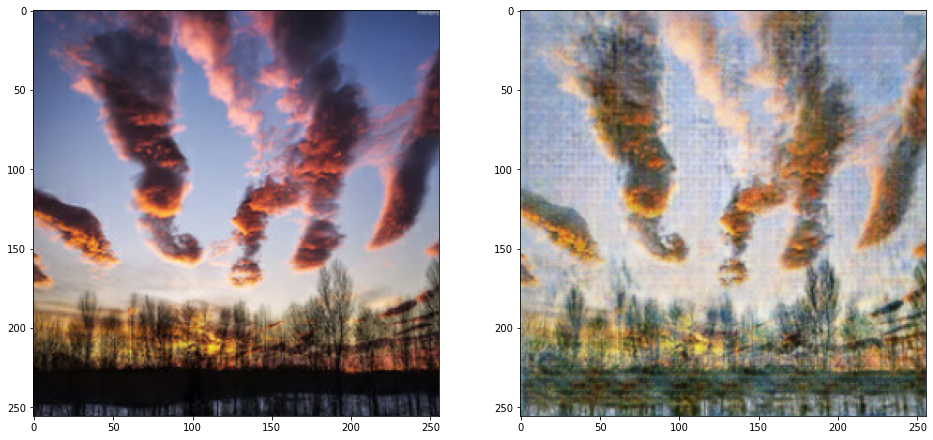

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(16,9))
ax = ax.flatten()
ax[0].imshow(photo_example[0]*0.5 + 0.5)
out  = (predict_img[0]*127.5 + 127.5).astype(np.uint8)
ax[1].imshow(out)

In [40]:
monet_disc.save("../models/p2pmonet_cycle_discriminator_100.h5")

NotImplementedError: Layer InstanceNormalization has arguments in `__init__` and therefore must override `get_config`.

In [ ]:
photo_disc.save("../models/p2pphoto_cycle_discriminator_100.h5")

In [ ]:
monet_gen.save("../models/p2pmonet_cycle_generator_100.h5")

In [ ]:
photo_gen.save("../models/p2pphoto_cycle_generator_100.h5")